<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Saha Bulge - Investigation into Properties of DiaSources in Crowded Fields</b> <br>
Contact author: Erin Howard<br>
Last verified to run: October 13, 2023<br>
LSST Science Piplines version: w_2023_37<br>
Container Size: Medium <br>

## Table of Contents

1. [Setup](#section_1)
2. [Load Data](#section_2)
3. [Analyze Initial Data](#section_3)
4. [Target Variability - Initial Cut](#section_4)
5. [Target Variability - Secondary Cut](#section_5)
6. [Target Variability - Alternative Cut](#section_6)

## 1. <a id="section_1">Setup</a>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lsst.daf.butler as dafButler
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import apdb

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import functools
import operator
from IPython.display import Image, display

import lsst.afw.display as afwDisplay
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

In [2]:
badFlagList=['base_PixelFlags_flag_bad',
             'base_PixelFlags_flag_suspect',
             'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_interpolated',
             'base_PixelFlags_flag_interpolatedCenter',
             'base_PixelFlags_flag_edge',
             ]

## 2. <a id="section_2">Load Data</a>

In [3]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'DECam'
skymap = 'hsc_rings_v1'

fakeStatus = 'with fakes'

dmnum = '40832'
collections_g = f'u/elhoward/DM-{dmnum}/saha_bulge/g'
schema_g = f'elhoward_dm{dmnum}_saha_g_appipe'

collections_i = f'u/elhoward/DM-{dmnum}/saha_bulge/i'
schema_i = f'elhoward_dm{dmnum}_saha_i_appipe'

collectionsList = [collections_g,collections_i]

In [4]:
apdbQuery_g = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema_g)

In [5]:
with apdbQuery_g.connection as connection:
    srcTable_g = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "dec" AS "decl", "ccdVisitId", \
                                 "psfFlux" AS "psFlux", "psfFluxErr" AS "psFluxErr", \
                                 "scienceFlux" AS "totFlux", "scienceFluxErr" AS "totFluxErr", "snr", \
                                 "flags", "band" AS "filterName" \
                                 FROM "{}"."DiaSource";'.format(schema_g), connection)

In [6]:
with apdbQuery_g.connection as connection:
    objTable_g = pd.read_sql_query('SELECT * \
                                 FROM "{}"."DiaObject" \
                                 WHERE ("validityEnd" is NULL) \
                                 ORDER BY "g_psfFluxStetsonJ";'.format(schema_g), connection)

In [7]:
flagTable_g, _, _, goodSrc_g, goodObj_g = utils.makeSrcTableFlags(srcTable_g, objTable_g, badFlagList, instrument, repo)

In [8]:
apdbQuery_i = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema_i)

In [9]:
with apdbQuery_i.connection as connection:
    srcTable_i = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "dec" AS "decl", "ccdVisitId", \
                                 "psfFlux" AS "psFlux", "psfFluxErr" AS "psFluxErr", \
                                 "scienceFlux" AS "totFlux", "scienceFluxErr" AS "totFluxErr", "snr", \
                                 "flags", "band" AS "filterName" \
                                 FROM "{}"."DiaSource";'.format(schema_i), connection)

In [10]:
with apdbQuery_i.connection as connection:
    objTable_i = pd.read_sql_query('SELECT * \
                                 FROM "{}"."DiaObject" \
                                 WHERE "validityEnd" is NULL \
                                 ORDER BY "i_psfFluxStetsonJ";'.format(schema_i), connection)

In [11]:
flagTable_i, _, _, goodSrc_i, goodObj_i = utils.makeSrcTableFlags(srcTable_i, objTable_i, badFlagList, instrument, repo)

## <a id="section_3">3. Analyze Initial Data</a>

### `g` band

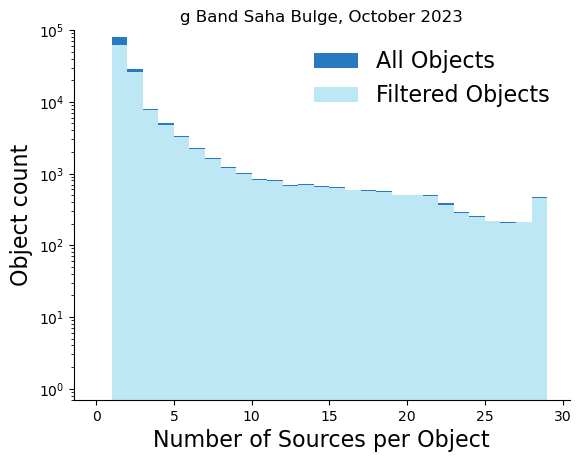

In [12]:
hist = plac.plotDiaObjectHistogram(objTable_g, goodObj_g, title=f'g Band Saha Bulge, October 2023')

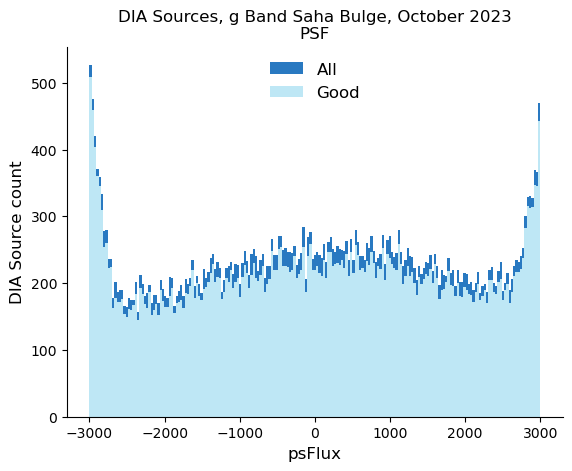

In [13]:
plac.plotFluxHistSrc(srcTable_g, goodSrc_g, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, g Band Saha Bulge, October 2023\nPSF')

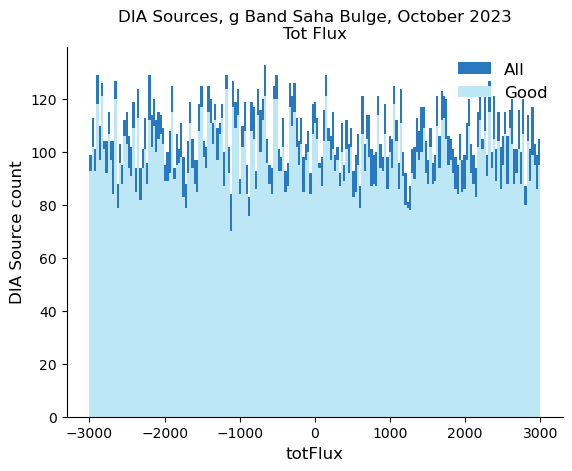

In [14]:
plac.plotFluxHistSrc(srcTable_g, goodSrc_g, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, g Band Saha Bulge, October 2023\nTot Flux')

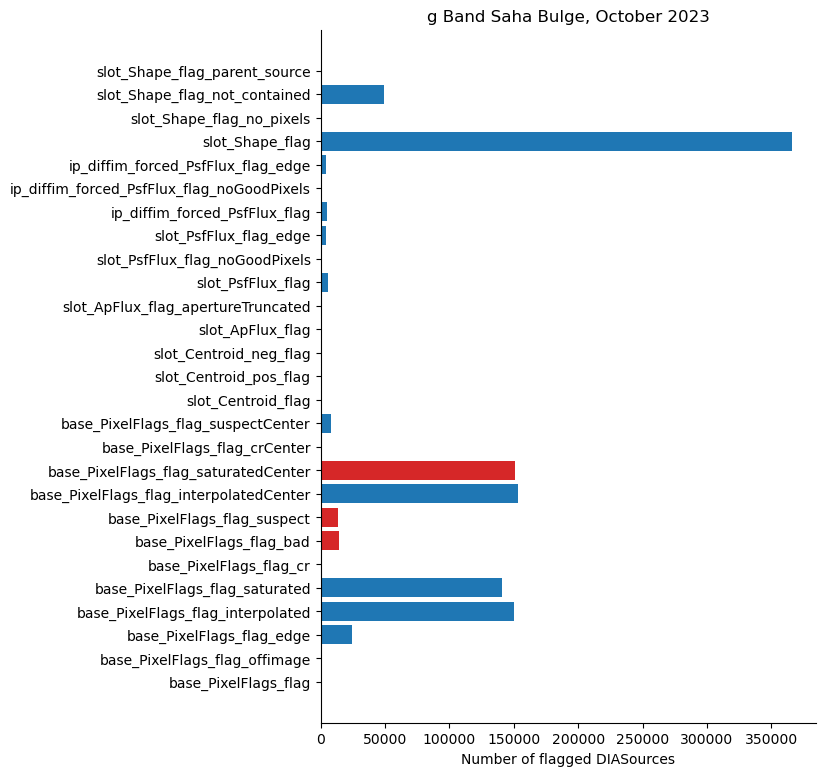

In [15]:
plac.plotFlagHist(srcTable_i, title=f'g Band Saha Bulge, October 2023')

### `i` band

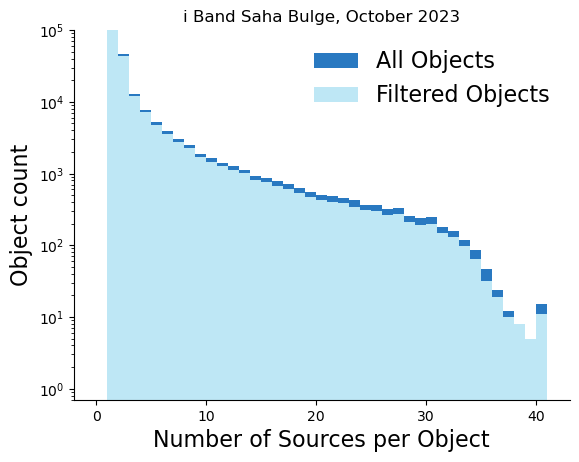

In [16]:
hist = plac.plotDiaObjectHistogram(objTable_i, goodObj_i, title=f'i Band Saha Bulge, October 2023')

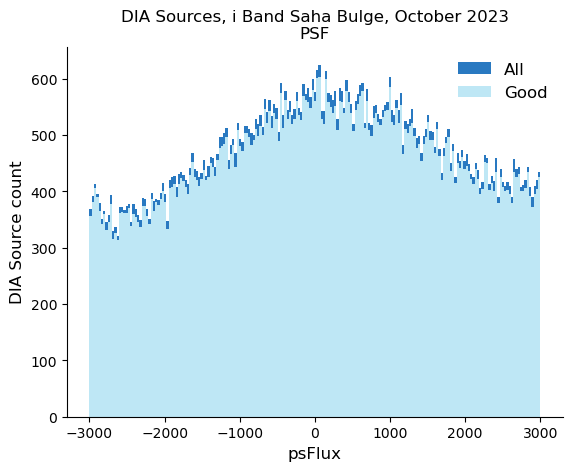

In [17]:
plac.plotFluxHistSrc(srcTable_i, goodSrc_i, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, i Band Saha Bulge, October 2023\nPSF')

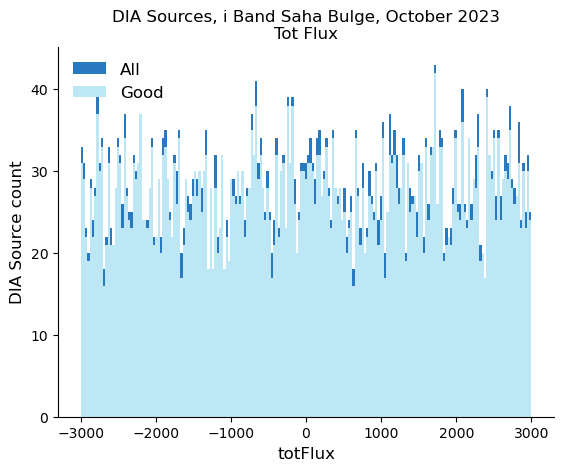

In [18]:
plac.plotFluxHistSrc(srcTable_i, goodSrc_i, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, i Band Saha Bulge, October 2023\nTot Flux')

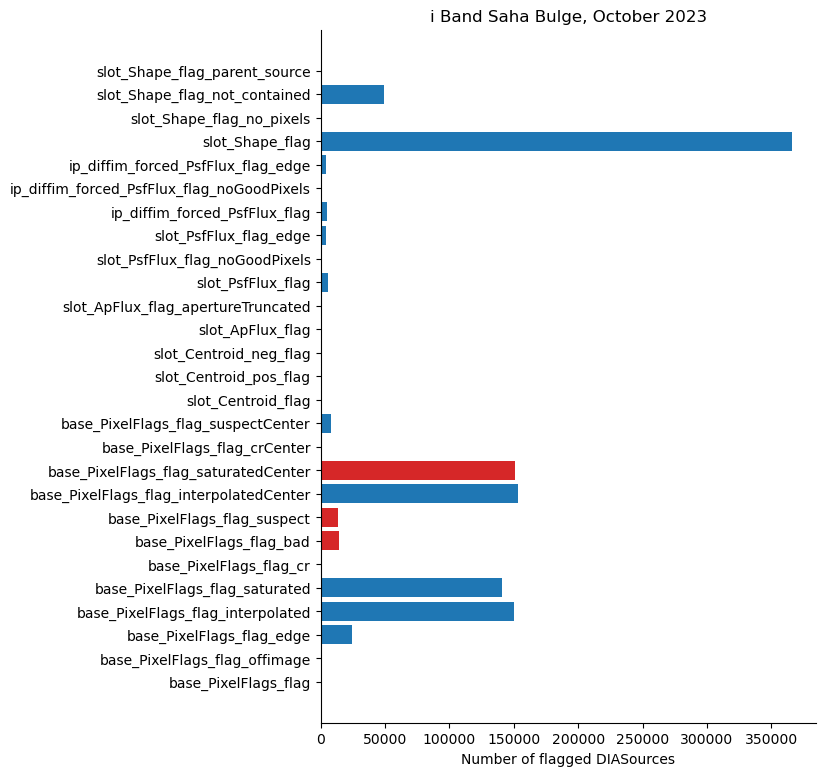

In [19]:
plac.plotFlagHist(srcTable_i, title=f'i Band Saha Bulge, October 2023')

## <a id="section_4">4. Target Variability - Initial Cut</a>

In [20]:
variableSample_g = goodObj_g.iloc[np.where((goodObj_g["g_psfFluxMin"] < 0) & 
                                           (goodObj_g["g_psfFluxMax"] > 0) &
                                           (goodObj_g["nDiaSources"] > 20))].reset_index(drop=True)

In [21]:
variableSample_g["psfFluxDiff"] = variableSample_g["g_psfFluxMax"] - variableSample_g["g_psfFluxMin"]

In [22]:
variableSample_i = goodObj_i.iloc[np.where((goodObj_i["i_psfFluxMin"] < 0) & 
                                           (goodObj_i["i_psfFluxMax"] > 0) &
                                           (goodObj_i["nDiaSources"] > 20))].reset_index(drop=True)

In [23]:
variableSample_i["psfFluxDiff"] = variableSample_i["i_psfFluxMax"] - variableSample_i["i_psfFluxMin"]

#### Plots against Science Flux Mean

Text(0, 0.5, 'Science Flux Sigma')

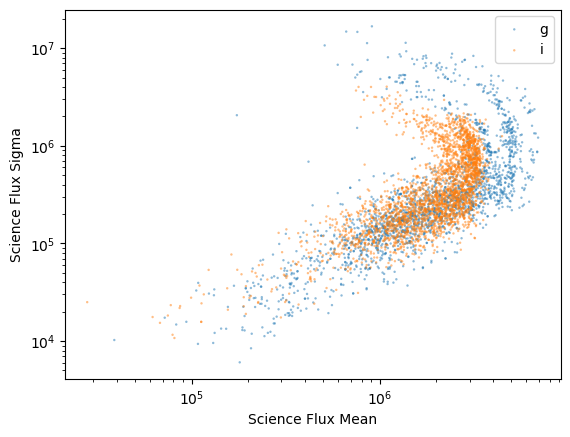

In [24]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'g_scienceFluxSigma'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_scienceFluxSigma'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("Science Flux Sigma")

Text(0, 0.5, 'PSF Flux MAD')

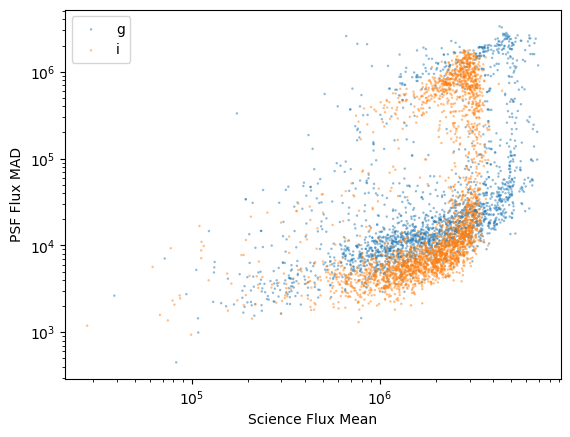

In [25]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'g_psfFluxMAD'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_psfFluxMAD'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("PSF Flux MAD")

Text(0, 0.5, 'PSF Flux Skew')

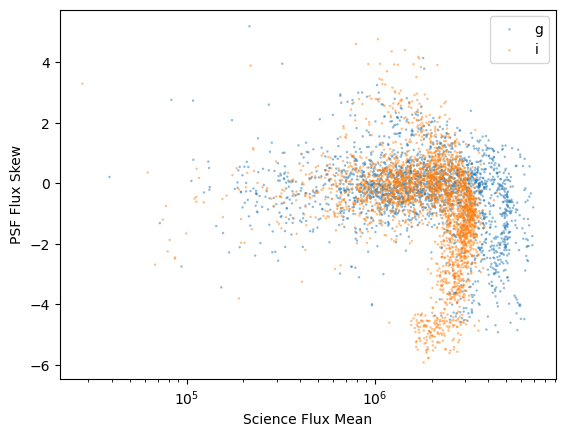

In [26]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'g_psfFluxSkew'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_psfFluxSkew'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("PSF Flux Skew")

Text(0, 0.5, 'PSF Flux StetsonJ')

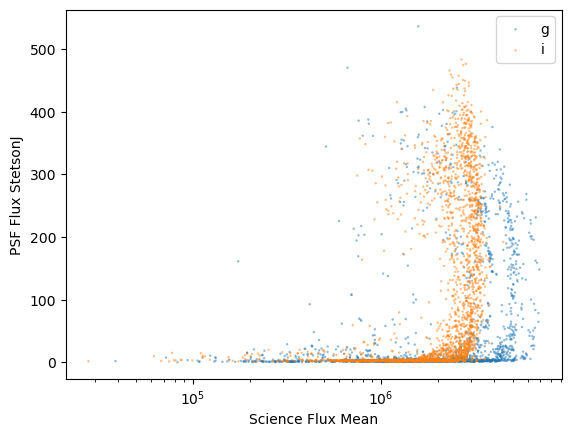

In [27]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'g_psfFluxStetsonJ'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_psfFluxStetsonJ'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("PSF Flux StetsonJ")

Text(0, 0.5, 'PSF Flux Diff (Max-Min)')

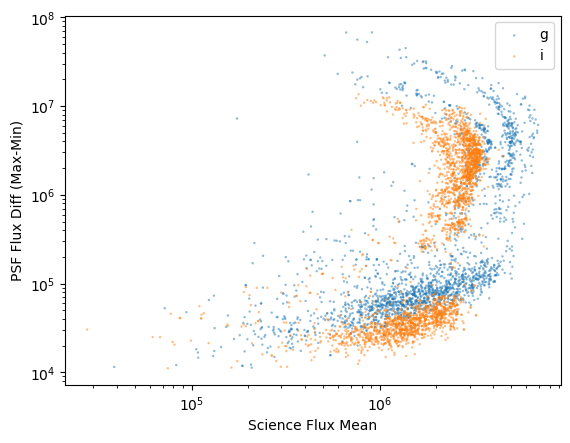

In [28]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'psfFluxDiff'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'psfFluxDiff'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("PSF Flux Diff (Max-Min)")

Text(0, 0.5, 'PSF Flux Max Slope')

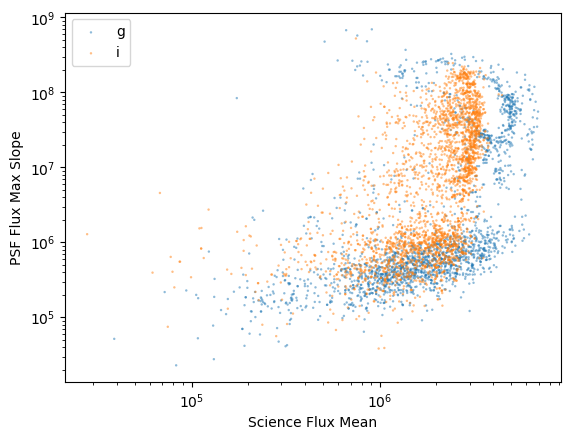

In [29]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'g_psfFluxMaxSlope'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_psfFluxMaxSlope'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("PSF Flux Max Slope")

#### Plots against Sigma

Text(0, 0.5, 'PSF Flux MAD')

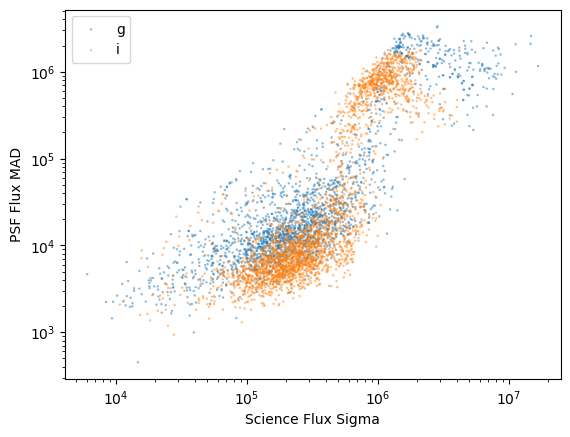

In [30]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxSigma'], 
            variableSample_g[f'g_psfFluxMAD'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxSigma'], 
            variableSample_i[f'i_psfFluxMAD'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Sigma")
plt.ylabel("PSF Flux MAD")

Text(0, 0.5, 'PSF Flux Skew')

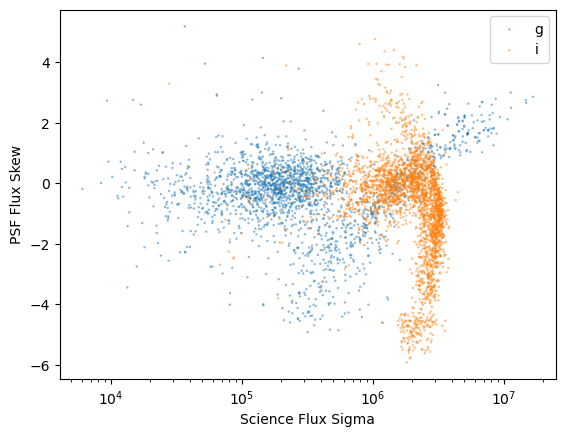

In [31]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxSigma'], 
            variableSample_g[f'g_psfFluxSkew'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_psfFluxSkew'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.xlabel("Science Flux Sigma")
plt.ylabel("PSF Flux Skew")

Text(0, 0.5, 'PSF Flux StetsonJ')

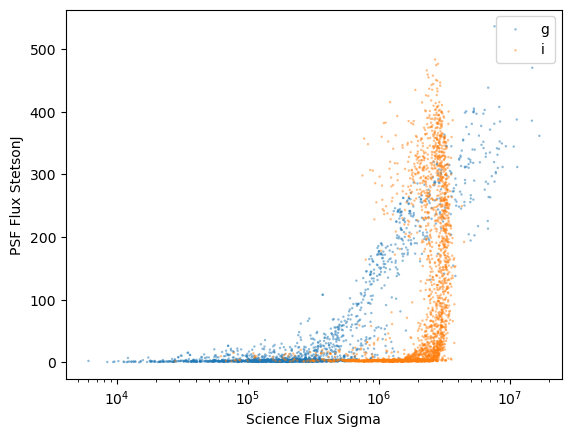

In [32]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxSigma'], 
            variableSample_g[f'g_psfFluxStetsonJ'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_psfFluxStetsonJ'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.xlabel("Science Flux Sigma")
plt.ylabel("PSF Flux StetsonJ")

Text(0, 0.5, 'PSF Flux Diff (Max-Min)')

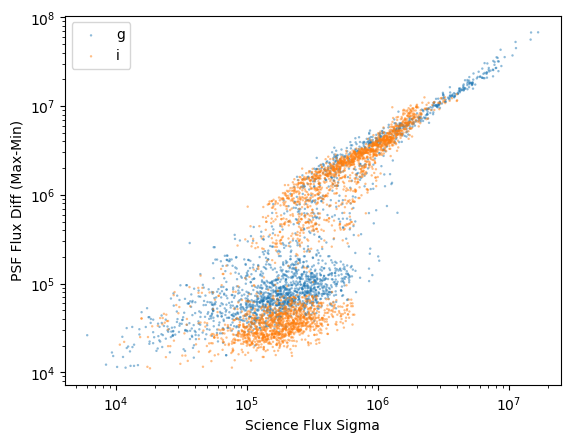

In [33]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxSigma'], 
            variableSample_g[f'psfFluxDiff'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxSigma'], 
            variableSample_i[f'psfFluxDiff'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Sigma")
plt.ylabel("PSF Flux Diff (Max-Min)")

Text(0, 0.5, 'PSF Flux Max Slope')

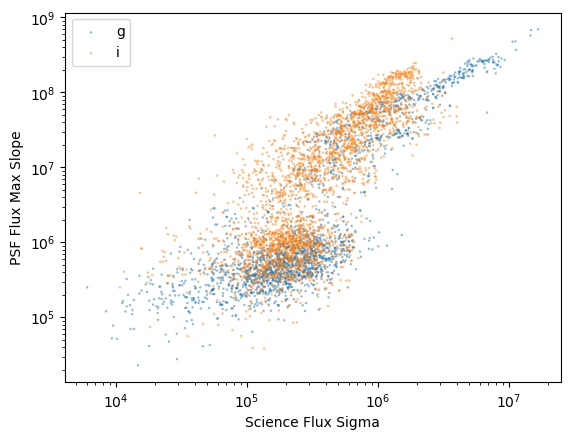

In [34]:
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxSigma'], 
            variableSample_g[f'g_psfFluxMaxSlope'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxSigma'], 
            variableSample_i[f'i_psfFluxMaxSlope'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Sigma")
plt.ylabel("PSF Flux Max Slope")

## <a id="section_5">5. Target Variability - Secondary Cut</a>

Text(0, 0.5, 'Science Flux Sigma')

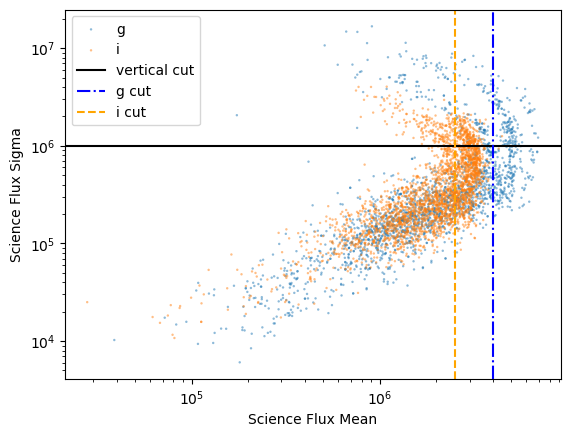

In [35]:
# Targetting a small portion of the objects that start curving backward.
plt.figure()
plt.scatter(variableSample_g[f'g_scienceFluxMean'], 
            variableSample_g[f'g_scienceFluxSigma'],
            edgecolor='none',alpha=0.5, label="g", s=3)
plt.scatter(variableSample_i[f'i_scienceFluxMean'], 
            variableSample_i[f'i_scienceFluxSigma'],
            edgecolor='none',alpha=0.5, label="i", s=3)
plt.axhline(y=1e6, color="black", linestyle='-', label="vertical cut")
plt.axvline(x=4e6, color="blue", linestyle='-.', label="g cut")
plt.axvline(x=2.5e6, color="orange", linestyle='--', label="i cut")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Science Flux Mean")
plt.ylabel("Science Flux Sigma")

In [36]:
variableSample_g2 = variableSample_g.iloc[np.where((variableSample_g["g_scienceFluxSigma"] > 1e6) & 
                                                   (variableSample_g["g_scienceFluxMean"] < 4e6))].reset_index(drop=True)

In [37]:
len(variableSample_g2)

195

In [38]:
len(set(variableSample_g2["diaObjectId"]))

156

In [39]:
variableSample_i2 = variableSample_i.iloc[np.where((variableSample_i["i_scienceFluxSigma"] > 1e6) & 
                                                   (variableSample_i["i_scienceFluxMean"] < 2.5e6))].reset_index(drop=True)

In [40]:
len(variableSample_i2)

197

In [41]:
len(set(variableSample_i2["diaObjectId"]))

191

#### Lightcurves of Selected Objects

##### `g` Band

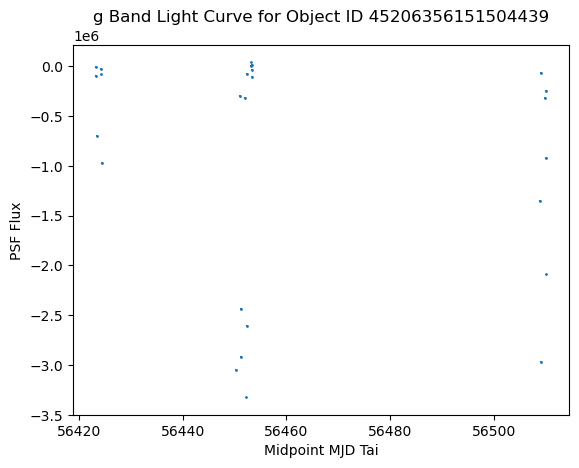

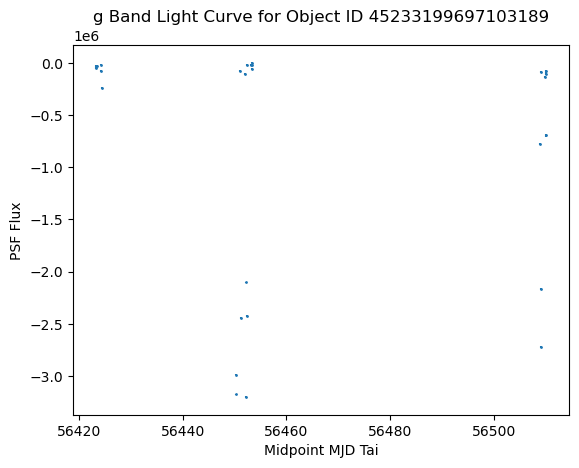

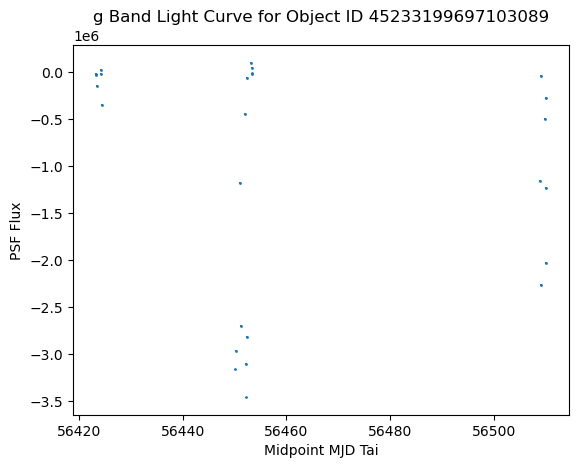

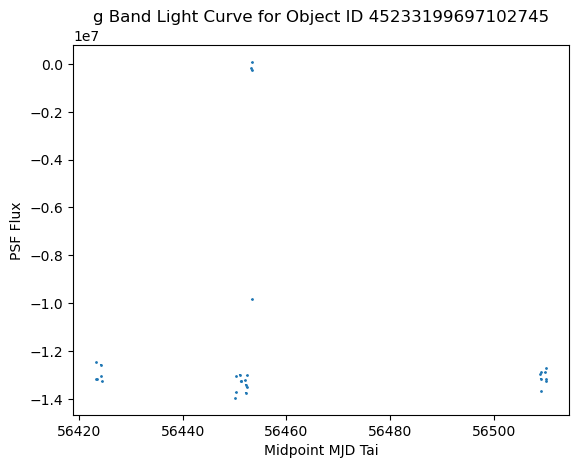

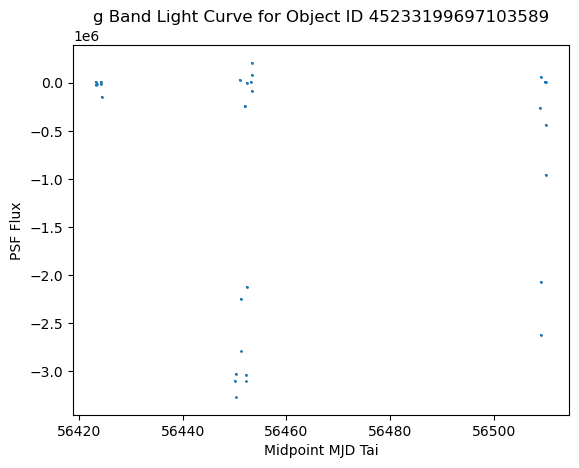

In [42]:
all_sources_g = {}

i = 0

for dia_object in variableSample_g2["diaObjectId"]:
    sources = apdbQuery_g.load_sources_for_object(dia_object)
    all_sources_g[dia_object] = sources.copy()
    
    # Only plotting the first five!
    if i < 5:
        plt.figure()
        plt.errorbar(sources["midpointMjdTai"],sources["psfFlux"], yerr=sources["psfFluxErr"], fmt="o", markersize=1)
        plt.title(f"g Band Light Curve for Object ID {dia_object}")
        plt.xlabel("Midpoint MJD Tai")
        plt.ylabel("PSF Flux")
        plt.show()
    i += 1

##### `i` Band

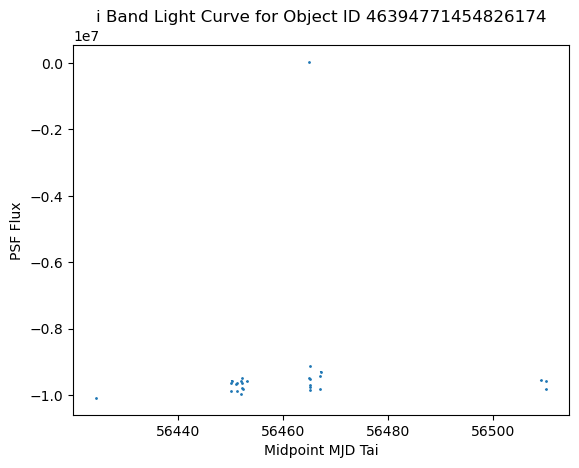

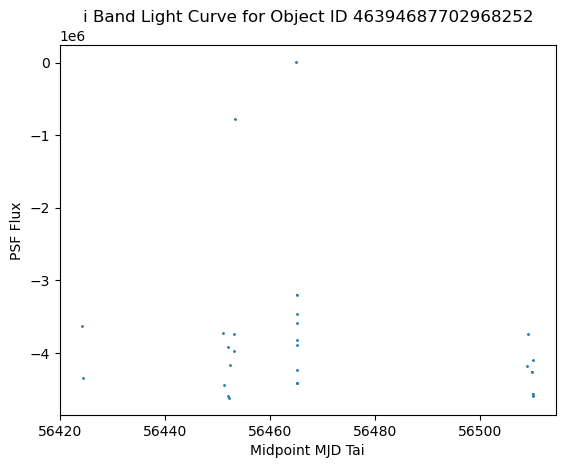

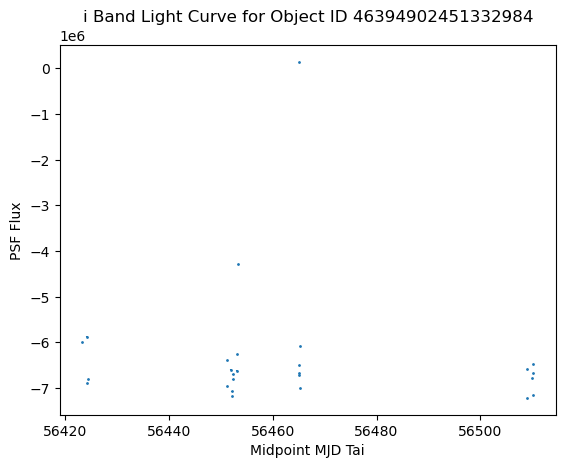

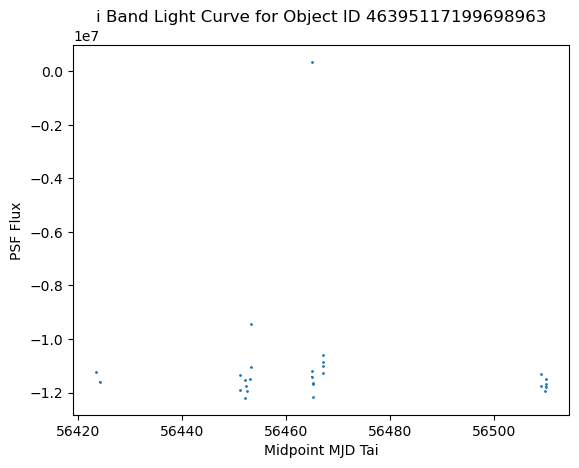

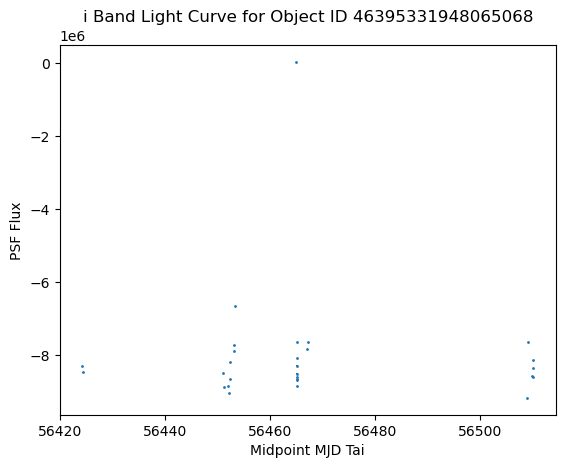

In [43]:
all_sources_i = {}

i = 0

for dia_object in variableSample_i2["diaObjectId"]:
    sources = apdbQuery_i.load_sources_for_object(dia_object)
    all_sources_i[dia_object] = sources.copy()
    
    # Only plotting the first five!
    if i < 5:
        plt.figure()
        plt.errorbar(sources["midpointMjdTai"],sources["psfFlux"], yerr=sources["psfFluxErr"], fmt="o", markersize=1)
        plt.title(f"i Band Light Curve for Object ID {dia_object}")
        plt.xlabel("Midpoint MJD Tai")
        plt.ylabel("PSF Flux")
        plt.show()
    i += 1

## <a id="section_6">Target Variability - Alternative Cut</a>

Text(0.5, 0, 'psfFluxMax-psfFluxMin')

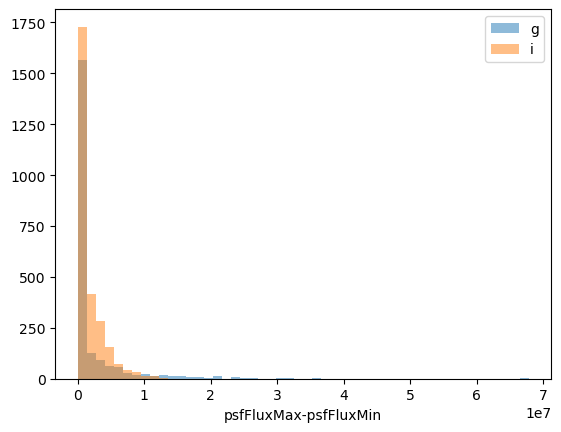

In [44]:
plt.hist(variableSample_g["psfFluxDiff"],alpha=0.5,bins=50, label='g')
plt.hist(variableSample_i["psfFluxDiff"],alpha=0.5,bins=10, label='i')
plt.legend()
plt.xlabel("psfFluxMax-psfFluxMin")

In [45]:
variableSample_g3 = variableSample_g.iloc[np.where(variableSample_g["psfFluxDiff"] > 1e7)].reset_index(drop=True)

In [46]:
variableSample_i3 = variableSample_i.iloc[np.where(variableSample_i["psfFluxDiff"] > 1e7)].reset_index(drop=True)

Text(0.5, 0, 'psfFluxMax-psfFluxMin')

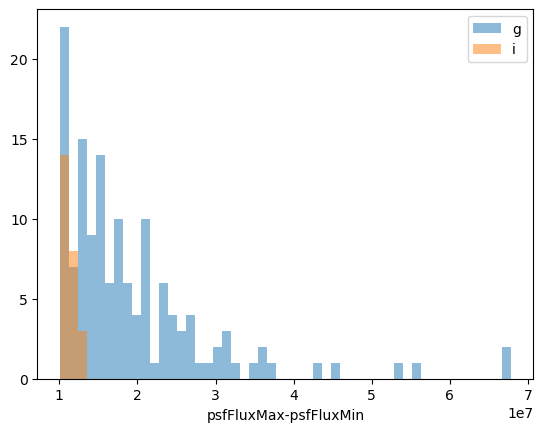

In [47]:
plt.hist(variableSample_g3["psfFluxDiff"],alpha=0.5,bins=50, label='g')
plt.hist(variableSample_i3["psfFluxDiff"],alpha=0.5,bins=3, label='i')
plt.legend()
plt.xlabel("psfFluxMax-psfFluxMin")

In [48]:
len(variableSample_g3)

139

In [49]:
len(set(variableSample_g3["diaObjectId"]))

122

In [50]:
len(variableSample_i3)

25

In [51]:
len(set(variableSample_i3["diaObjectId"]))

25

#### Lightcurves of Selected Objects

##### `g` Band

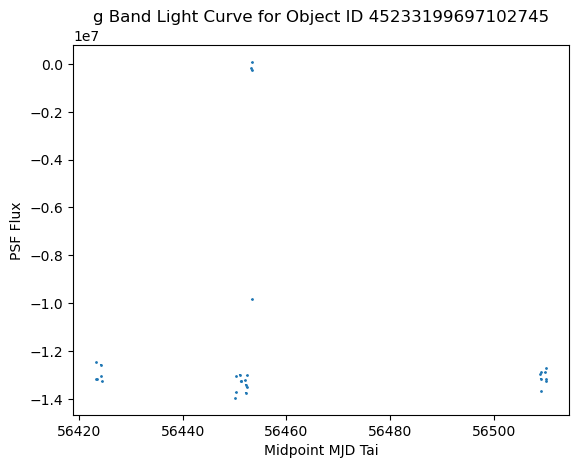

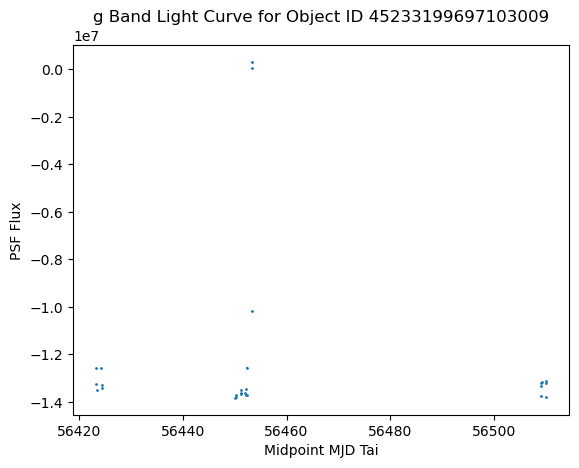

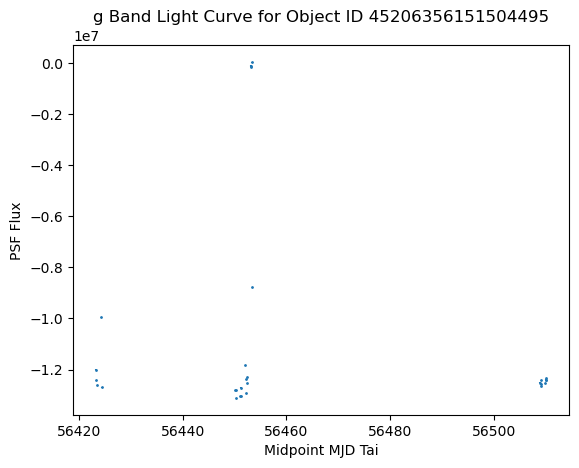

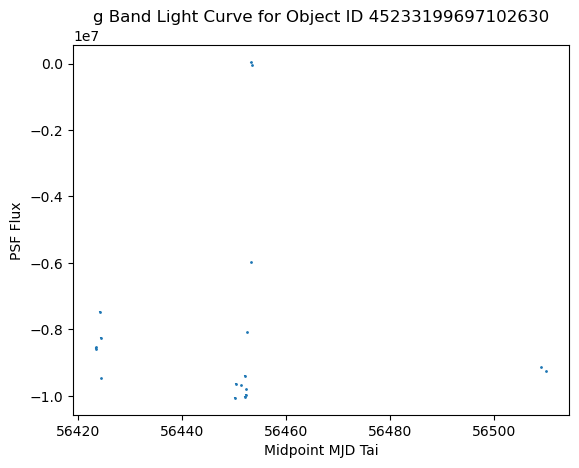

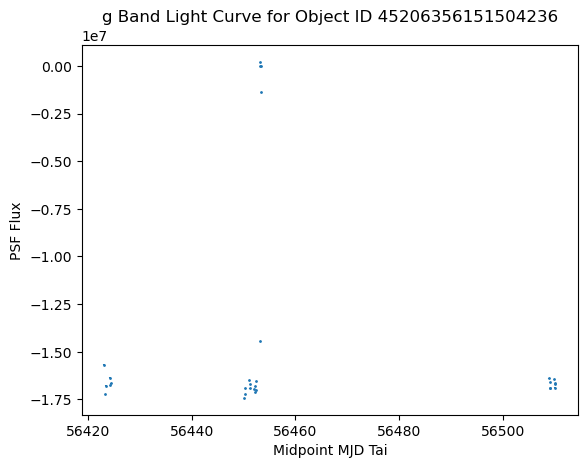

In [52]:
all_sources_g = {}

i = 0

for dia_object in variableSample_g3["diaObjectId"]:
    sources = apdbQuery_g.load_sources_for_object(dia_object)
    all_sources_g[dia_object] = sources.copy()
    
    # Only plotting the first five!
    if i < 5:
        plt.figure()
        plt.errorbar(sources["midpointMjdTai"],sources["psfFlux"], yerr=sources["psfFluxErr"], fmt="o", markersize=1)
        plt.title(f"g Band Light Curve for Object ID {dia_object}")
        plt.xlabel("Midpoint MJD Tai")
        plt.ylabel("PSF Flux")
        plt.show()
    i += 1

##### `i` Band

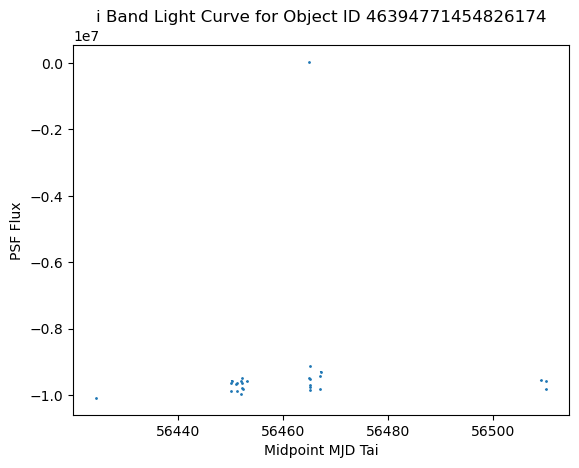

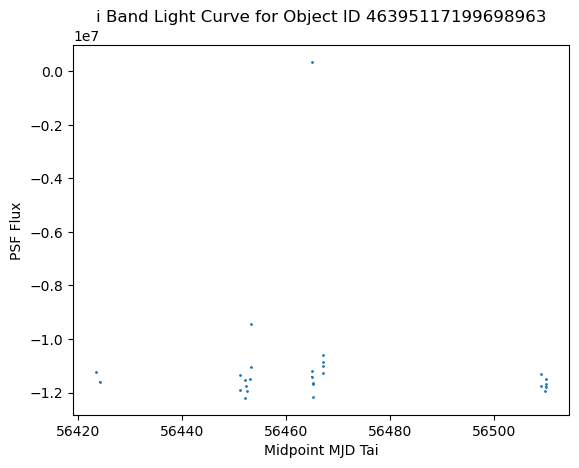

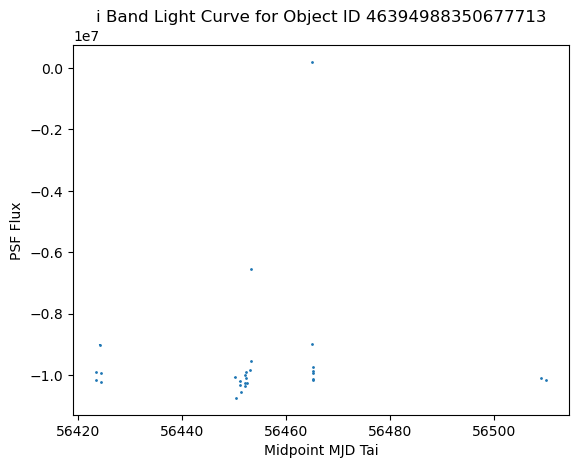

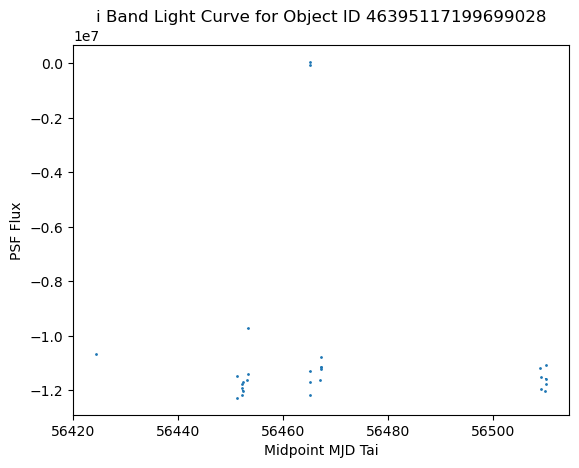

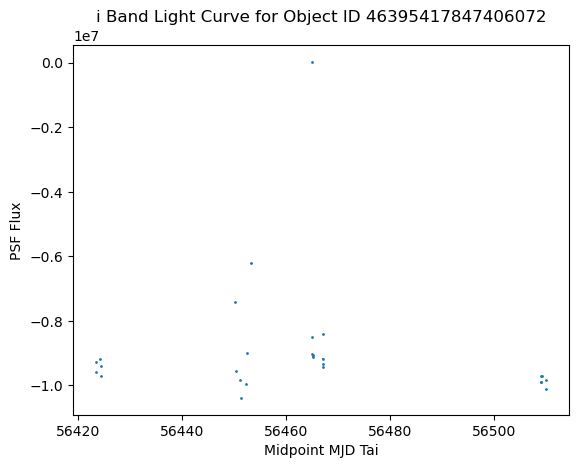

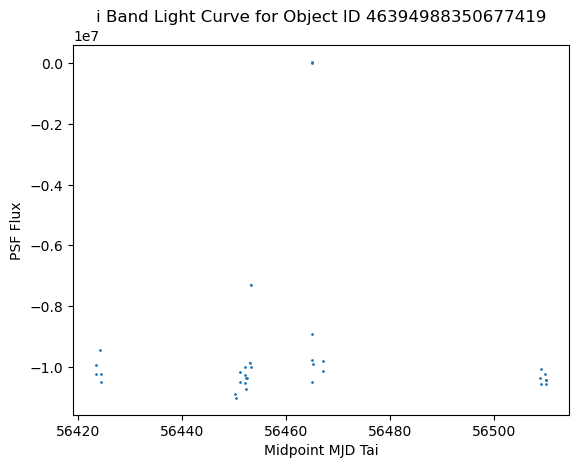

In [53]:
all_sources_i = {}

i = 0

for dia_object in variableSample_i3["diaObjectId"]:
    sources = apdbQuery_i.load_sources_for_object(dia_object)
    all_sources_i[dia_object] = sources.copy()

    # Only plotting the first five!
    if i <= 5:
        plt.figure()
        plt.errorbar(sources["midpointMjdTai"],sources["psfFlux"], yerr=sources["psfFluxErr"], fmt="o", markersize=1)
        plt.title(f"i Band Light Curve for Object ID {dia_object}")
        plt.xlabel("Midpoint MJD Tai")
        plt.ylabel("PSF Flux")
        plt.show()
    i += 1